# San Benito River, California:
## Trends in flashiness of streamflow and precipitation

Sources:
https://www.earthdatascience.org/tutorials/acquire-and-visualize-usgs-hydrology-data/

https://github.com/sativa/hydro-1

http://climata.houstoneng.net/

For selecting USGS stations and available data, see

https://maps.waterdata.usgs.gov/mapper/

Build a Pandas dataframe with datetime index and columns for streamflow and precipitation, choosing one or more precipitation stations that are well located within the watershed above the stream gauge.




In [1]:
#basic imports
import matplotlib.pyplot as plt
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import pandas as pd
import numpy as np
import folium  #folium on Jupyter doesn't do well in Microsoft Edge. Chrome works.
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 9]

In [2]:
#some functions
def flashiness(series):
    """Richards-Baker Flashiness Index for a Pandas series of daily mean flows = the path length divided by the sum."""
    Qsum = np.sum(series)           # sum of daily mean discharges
    Qpath = 0.0
    for i in range(len(series)):
        if i == 0:
            Qpath = series[i]       # first entry only
        else:
            Qpath += np.abs(series[i] - series[i-1])    # sum the absolute differences of the daily flows
    return Qpath/Qsum


def flow_duration(series):
    """Returns a Pandas series, a flow duration curve, whose index is the flow values and series is the frequency of exceeding a given flow."""
    fd = pd.Series(series).value_counts()               # frequency of unique values
    fd.sort_index(inplace=True)                         # sort in order of increasing flows
    fd = fd.cumsum()                                    # cumulative sum of frequencies
    fd = fd.apply(lambda x: 1 - x/fd.max() * 1)     # normalize
    return fd

## Streamflow
This river runs into the Pajaro river, which runs into the sea near Watsonville, and is considered part of the Pajaro basin (HUC 8 code: 18060002, 1290 square miles. Hernandez Reservoir and dam date from 1962, 18,000 acre-feet capacity.


In [3]:
startdate = "1939-01-01"
enddate = "2019-02-14"
station_id = "11156500" #San Benito River nr Willow Cr School
param_id = "00060" #stream flow in cfs
data = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    basin="18060002",
    #station=station_id,
    parameter=param_id,
)
list(data)

[DailyValueIOTuple(site_name='CEDAR C NR BELL STATION CA', site_code='11152900', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=37.0499451, longitude=-121.327431, data=<climata.parsers.TimeSeriesIO object at 0x000001EA86BA9CF8>),
 DailyValueIOTuple(site_name='PACHECO C NR DUNNEVILLE CA', site_code='11153000', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=36.98, longitude=-121.3802778, data=<climata.parsers.TimeSeriesIO object at 0x000001EA86C8F908>),
 DailyValueIOTuple(site_name='PACHECO C A DUNNEVILLE CA', site_code='11153040', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=36.95994927, longitude=-121.4179906, data=<climata.parsers.TimeSeriesIO object at 0x000001EA86C8F940>),
 DailyValueIOTuple(site_name='LLAGAS C AB CHESBRO RES NR MORGAN HILL CA', site_code='11153470', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=37.1483333, lo

In [4]:
#make dataframe
flows = pd.DataFrame([[y for y in x] for x in data], columns=['name','code','variable_name','variable_code','unit','lat','lon','data'])
starts = []
ends = []
#add start and end dates for flow data
for site in data:
    starts.append(site.data[0][0].strftime('%Y-%m-%d')) #the first date in the tuple
    ends.append(site.data[-1][0].strftime('%Y-%m-%d')) #the last date in the tuple
flows['start'] = starts
flows['end'] = ends

In [5]:
#San Benito R near Willow Creek school is the most consistent record. Site code 11156500
m = folium.Map(location=[36.9, -121.5], zoom_start=9, tiles="Stamen Terrain")
coords = [36,-121]
for i in range(0,len(flows)):
    folium.Marker([flows.iloc[i]['lat'], flows.iloc[i]['lon']],popup=flows.iloc[i]['start']+':'+flows.iloc[i]['end'],tooltip=flows.iloc[i]['name'], icon=folium.Icon(color='green')).add_to(m)
m

In [6]:
#make dataframe from this station
station_id = "11156500" #San Benito river nr Willow Creek School
param_id = "00060"

fdata = DailyValueIO(
    start_date='1939-01-01',
    end_date='2019-02-14',
    station=station_id,
    parameter=param_id,
)
list(fdata)

[DailyValueIOTuple(site_name='SAN BENITO R NR WILLOW CREEK SCHOOL CA', site_code='11156500', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=36.60940609, longitude=-121.2029797, data=<climata.parsers.TimeSeriesIO object at 0x000001EA89C3D4E0>)]

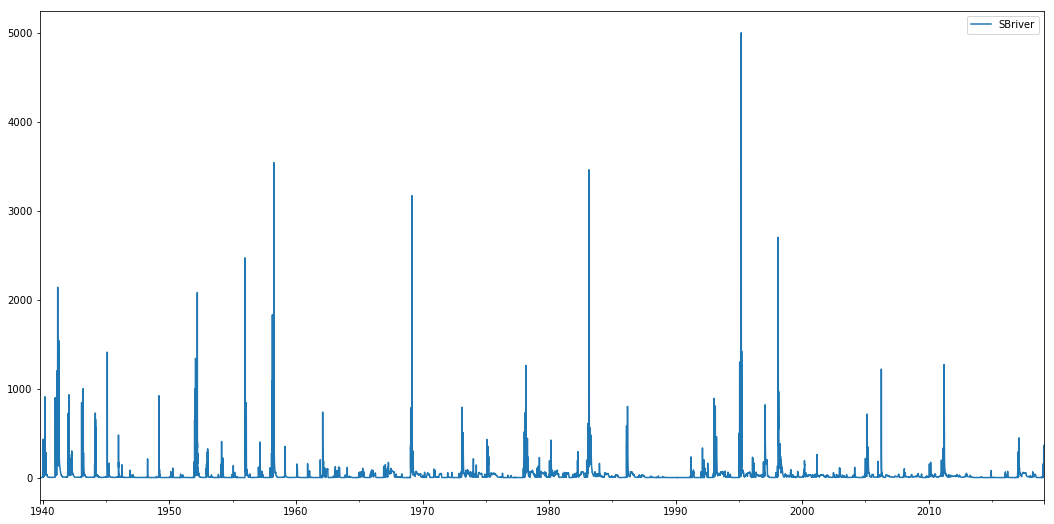

In [7]:
#after some inspection of the returned object, this is what we need:
dates = [r[0] for r in fdata[0][7]]
flows = [r[1] for r in fdata[0][7]]
sb = pd.DataFrame(flows,index=dates, columns=['SBriver'])
sb.plot()

## Precipitation

In [8]:
#what are available precipitation gauges in the basin?
pdata = StationDataIO(
    start_date='1939-01-01',
    end_date='2019-02-14',
    #basin="18060002", #Pajaro basin takes too long to retrieve, using San Benito county instead
    county='06069',
    parameter="pcpn",
)
list(pdata) 

[StationDataIOTuple(name='HERNANDEZ 7 SE', sids={'COOP': '043928', 'GHCN': 'USC00043928', 'NWSLI': 'HERC1'}, county='06069', state='CA', elev=2765.0, climdiv='CA04', uid=2495, longitude=-120.7047, latitude=36.3052, data=<climata.acis.DataIO object at 0x000001EA94C7E470>),
 StationDataIOTuple(name='PINNACLES NM', sids={'COOP': '046926', 'GHCN': 'USC00046926', 'NWSLI': 'PNMC1'}, county='06069', state='CA', elev=1307.0, climdiv='CA04', uid=2519, longitude=-121.1822, latitude=36.4819, data=<climata.acis.DataIO object at 0x000001EA94C7E898>),
 StationDataIOTuple(name='IDRIA', sids={'COOP': '044204', 'GHCN': 'USC00044204'}, county='06069', state='CA', elev=2651.0, climdiv='CA05', uid=2508, longitude=-120.66667, latitude=36.41667, data=<climata.acis.DataIO object at 0x000001EA94C7E908>),
 StationDataIOTuple(name='SAN BENITO', sids={'COOP': '047719', 'GHCN': 'USC00047719', 'NWSLI': 'SBDC1'}, county='06069', state='CA', elev=1355.0, climdiv='CA04', uid=2527, longitude=-121.08694, latitude=36.50

In [9]:
#basic dataframe for mapping etc.
precip = pd.DataFrame([[y for y in x] for x in pdata],
columns=['name','codes','county','st','r','a','b','lon','lat','data'])
#add precip gauges to map
for i in range(0,len(precip)):
    folium.Marker([precip.iloc[i]['lat'], precip.iloc[i]['lon']], tooltip=precip.iloc[i]['name'], icon=folium.Icon(icon='cloud')).add_to(m)
m

In [10]:
# create a dataframe of precipitation records
for i in range(0,len(pdata)):
    if i==0:
        dates = [r[0] for r in pdata[i].data]
        pcpn = [r[1] for r in pdata[i].data]
        p = pd.DataFrame(data = pcpn, columns = [pdata[i].name], index=dates)
    else:
        p[pdata[i].name] = [r[1] for r in pdata[i].data]
        
p.describe()

,HERNANDEZ 7 SE,PINNACLES NM,IDRIA,SAN BENITO,HERNANDEZ 2 NW,GONZALES 9 ENE,HOLLISTER 0.3 WSW,HOLLISTER 5.3 NNE,SAN JUAN BAUTISTA 0.5 S,SAN BENITO WILLOW CREEK,...,PANOCHE 2 W,HOLLISTER 2.1 ESE,UPPER TRES PINOS,PAICINES 4 W,BUENA VISTA,HOLLISTER 1 SW,SAN JUAN BAUTISTA 3 SS,HOLLISTER 2,HOLLISTER NAAS,STAYTON MINE
count,29265,29265.0,29265,29265,29265,29265,29265,29265,29265,29265,...,29265.0,29265,29265,29265.0,29265,29265,29265,29265,29265,29265
unique,69,254.0,187,60,184,61,81,69,48,92,...,181.0,95,58,204.0,62,142,72,200,18,78
top,M,0.0,M,M,M,M,M,M,M,M,...,0.0,M,M,0.0,M,M,M,M,M,M
freq,28192,22622.0,15704,28081,15820,28081,27550,28718,25887,27002,...,20903.0,25859,28085,19086.0,28115,16342,28106,14131,29139,28086


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EAAAE545F8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001EAB2D60400>], dtype=object)

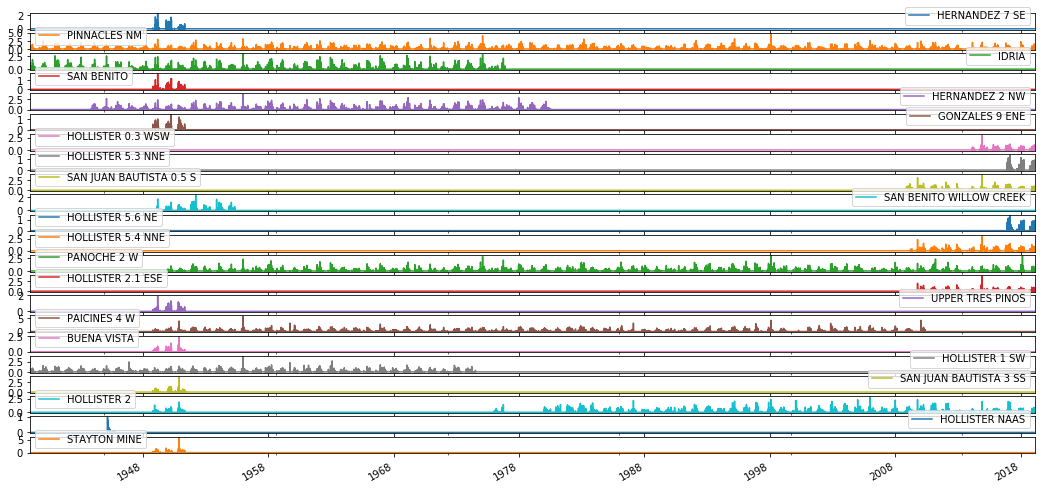

In [11]:
#replace text values so they can be plotted
p.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
p.plot(subplots=True) 

In [12]:
#from this it seems Pinnacles and Panoche are the ones to use, for most complete data records
p = p[['PINNACLES NM','PANOCHE 2 W']]
p.index = pd.to_datetime(p.index)

# Flashiness
of both streamflow and precipitation. For the 

In [14]:
#flashiness index on the flow
print('RB flashiness before dam: ',flashiness(sb['1939':'1962']['SBriver']))
print('RB flashiness after dam: ',flashiness(sb['1963':'2019']['SBriver']))


RB flashiness before dam:  0.501570673962
RB flashiness after dam:  0.240635505887


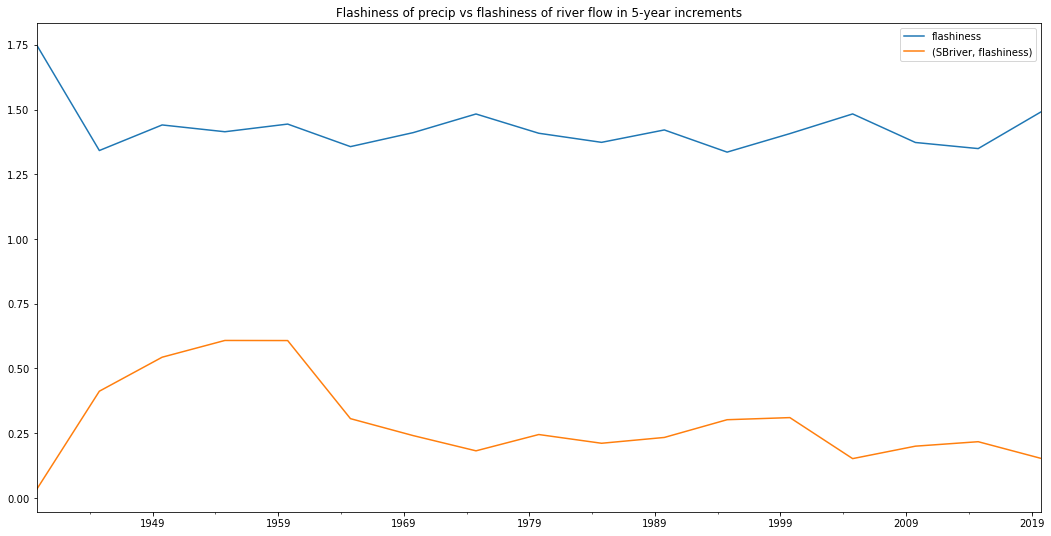

In [15]:
#re-jigger on California water year, Oct 1 to Sept 30, and group in 5-yr increments
pgroup = p['1939-10-01':'2018-09-30']['PINNACLES NM'].groupby(pd.Grouper(freq='60M')).agg({flashiness})
fgroup = sb['1939-10-01':'2018-09-30'].groupby(pd.Grouper(freq='60M')).agg({flashiness})
flash = pd.concat([pgroup,fgroup], axis=1)
flash.plot()
plt.title('Flashiness of precip vs flashiness of river flow in 5-year increments')

In [16]:
#try some annual figures, sum for precip and mean for flow
precipsums = p['1939-10-01':'2018-09-30'].resample('12M').sum()
flowmeans = sb['1939-10-01':'2018-09-30'].resample('12M').mean()
annual = pd.concat([precipsums, flowmeans], axis=1)
annual['ratio'] = annual['PINNACLES NM']/annual['SBriver']

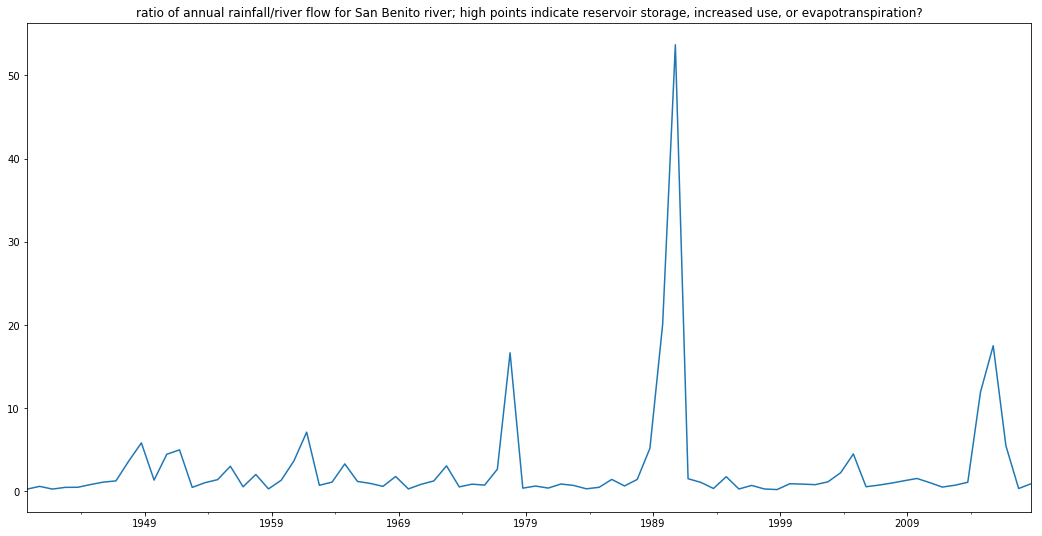

In [17]:
annual.ratio.plot()
plt.title('ratio of annual rainfall/river flow for San Benito river; high points indicate reservoir storage, increased use, or evapotranspiration?')

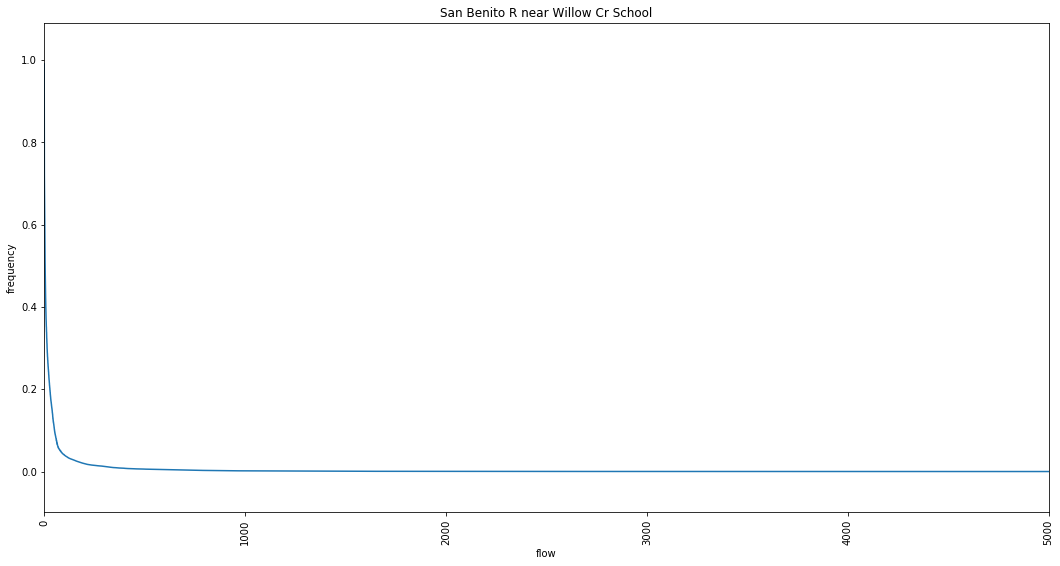

In [18]:
#flow duration curve; this could be rendered in 5-yr periods    
fdc = flow_duration(sb['SBriver'])
fdc.plot()
plt.xlabel('flow')
plt.ylabel('frequency')
plt.title('San Benito R near Willow Cr School')
plt.xticks(rotation='vertical')
plt.margins(.1)
plt.show()